In [1]:
# Import all libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    auc
)
from sklearn.preprocessing import label_binarize
import random
from collections import defaultdict

In [2]:
# Define emotion labels for the model
emotion_labels = {0: "Happy", 1: "Surprise", 2: "Sad", 3: "Anger", 4: "Disgust", 5: "Fear", 6: "Neutral"}

# Load and Preprocess RAF-DB Dataset
class RAFDBDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.label_map = {1: 1, 2: 5, 3: 4, 4: 0, 5: 2, 6: 3, 7: 6}
        self.image_data = []
        class_images = defaultdict(list)
        for class_folder in os.listdir(img_dir):
            class_path = os.path.join(img_dir, class_folder)
            if os.path.isdir(class_path) and class_folder.isdigit():
                label = int(class_folder)
                if label in self.label_map:
                    mapped_label = self.label_map[label]
                    for filename in os.listdir(class_path):
                        if any(filename.endswith(ext) for ext in (".jpg", ".png", ".jpeg", ".tiff")):
                            class_images[mapped_label].append((filename, label))
        anger_count = len(class_images[3])
        self.image_data = []
        for label, images in class_images.items():
            selected_images = random.sample(images, min(anger_count, len(images)))
            self.image_data.extend(selected_images)
        if not self.image_data:
            raise ValueError(f"No images found in {img_dir}")

    def __len__(self):
        return len(self.image_data)

    def __getitem__(self, idx):
        img_name, original_label = self.image_data[idx]
        mapped_label = self.label_map[original_label]
        img_path = os.path.join(self.img_dir, str(original_label), img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, mapped_label

# Load and Preprocess FER2013 Dataset
class FER2013Dataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.label_map = {'happy': 0, 'surprise': 1, 'sad': 2, 'angry': 3, 'disgust': 4, 'fear': 5, 'neutral': 6}
        self.image_data = []
        class_images = defaultdict(list)
        for emotion in os.listdir(img_dir):
            emotion_path = os.path.join(img_dir, emotion)
            if os.path.isdir(emotion_path) and emotion.lower() in self.label_map:
                label = self.label_map[emotion.lower()]
                for filename in os.listdir(emotion_path):
                    if any(filename.endswith(ext) for ext in (".jpg", ".png", ".jpeg", ".tiff")):
                        class_images[label].append((os.path.join(emotion_path, filename), label))
        anger_count = len(class_images[3])
        self.image_data = []
        for label, images in class_images.items():
            selected_images = random.sample(images, min(anger_count, len(images)))
            self.image_data.extend(selected_images)
        if not self.image_data:
            raise ValueError(f"No images found in {img_dir}")

    def __len__(self):
        return len(self.image_data)

    def __getitem__(self, idx):
        img_path, label = self.image_data[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Load and Preprocess AffectNet Dataset with Oversampling for Disgust
class AffectNetDataset(Dataset):
    def __init__(self, img_dir, transform=None, oversample_disgust=False, target_disgust_count=6200):
        self.img_dir = img_dir
        self.transform = transform
        self.label_map = {'happy': 0, 'surprise': 1, 'sad': 2, 'anger': 3, 'disgust': 4, 'fear': 5, 'neutral': 6}
        self.image_data = []
        class_images = defaultdict(list)
        # print(f"Checking directory: {img_dir}")
        # print(f"Contents: {os.listdir(img_dir)}")
        for emotion in os.listdir(img_dir):
            emotion_path = os.path.join(img_dir, emotion)
            emotion_lower = emotion.lower()
            if os.path.isdir(emotion_path) and emotion_lower in self.label_map:
                label = self.label_map[emotion_lower]
                # print(f"Checking subfolder: {emotion_path}")
                subfolder_contents = os.listdir(emotion_path)
                # print(f"Subfolder contents: {subfolder_contents}")
                for filename in subfolder_contents:
                    if any(filename.endswith(ext) for ext in (".jpg", ".png", ".jpeg", ".tiff")):
                        class_images[label].append((os.path.join(emotion_path, filename), label))
        anger_count = len(class_images[3])
        self.image_data = []
        if oversample_disgust and 4 in class_images:
            disgust_data = class_images[4]
            other_data = [(path, label) for label, images in class_images.items() if label != 4 for path, label in images]
            current_disgust_count = len(disgust_data)
            if current_disgust_count > 0:
                oversample_factor = max(1, target_disgust_count // current_disgust_count)
                # print(f"Oversampling Disgust: {current_disgust_count} images -> {oversample_factor * current_disgust_count} images")
                for _ in range(oversample_factor):
                    self.image_data.extend(disgust_data)
                self.image_data.extend(disgust_data[:target_disgust_count % current_disgust_count])
            self.image_data.extend(other_data)
            for label, images in class_images.items():
                if label != 4:
                    selected_images = random.sample(images, min(anger_count, len(images)))
                    self.image_data.extend(selected_images)
        else:
            for label, images in class_images.items():
                selected_images = random.sample(images, min(anger_count, len(images)))
                self.image_data.extend(selected_images)
        if not self.image_data:
            raise ValueError(f"No images found in {img_dir}")

    def __len__(self):
        return len(self.image_data)

    def __getitem__(self, idx):
        img_path, label = self.image_data[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Define transforms
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomAffine(degrees=15, translate=(0.05, 0.05), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load RAF-DB datasets
base_path_rafdb = "/kaggle/input/raf-db-dataset"
train_img_dir_rafdb = os.path.join(base_path_rafdb, "DATASET/train")
test_img_dir_rafdb = os.path.join(base_path_rafdb, "DATASET/test")

# Load FER-2013 datasets
base_path_fer2013 = "/kaggle/input/fer2013"
train_img_dir_fer2013 = os.path.join(base_path_fer2013, "train")
test_img_dir_fer2013 = os.path.join(base_path_fer2013, "test")

# Load AffectNet datasets
base_path_affectnet = "/kaggle/input/affectnet/archive (3)"
train_img_dir_affectnet = os.path.join(base_path_affectnet, "Train")
test_img_dir_affectnet = os.path.join(base_path_affectnet, "Test")

# Check paths if they exist
for path in [train_img_dir_rafdb, test_img_dir_rafdb, train_img_dir_fer2013, test_img_dir_fer2013, train_img_dir_affectnet, test_img_dir_affectnet]:
    if not os.path.exists(path):
        print(f"Warning: Directory not found at {path}")

# Load RAF-DB, FER-2013, and AffectNet training datasets
rafdb_train_dataset = RAFDBDataset(img_dir=train_img_dir_rafdb, transform=train_transforms)
fer2013_train_dataset = FER2013Dataset(img_dir=train_img_dir_fer2013, transform=train_transforms)
affectnet_train_dataset = AffectNetDataset(img_dir=train_img_dir_affectnet, transform=train_transforms, oversample_disgust=True, target_disgust_count=6200)

# Combine training datasets
full_train_dataset = ConcatDataset([rafdb_train_dataset, fer2013_train_dataset, affectnet_train_dataset])

# Split into train and validation sets
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(
    full_train_dataset, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

# Load test datasets
rafdb_test_dataset = RAFDBDataset(img_dir=test_img_dir_rafdb, transform=test_transforms)
fer2013_test_dataset = FER2013Dataset(img_dir=test_img_dir_fer2013, transform=test_transforms)
# print(f"Attempting to load AffectNet test dataset from: {test_img_dir_affectnet}")
try:
    affectnet_test_dataset = AffectNetDataset(img_dir=test_img_dir_affectnet, transform=test_transforms)
except ValueError as e:
    print(f"Error loading AffectNet test dataset: {e}")
    print("Falling back to using validation set as test set.")
    affectnet_test_dataset = None

# Combine test datasets
combined_test_dataset = ConcatDataset([rafdb_test_dataset, fer2013_test_dataset])
if affectnet_test_dataset is not None:
    combined_test_dataset = ConcatDataset([combined_test_dataset, affectnet_test_dataset])

# Print dataset sizes
print(f"Total Training Data (RAF-DB + FER-2013 + AffectNet): {len(full_train_dataset)}")
print(f"Training Split: {len(train_dataset)}")
print(f"Validation Split: {len(val_dataset)}")
print(f"Test Set (RAF-DB + FER-2013 + AffectNet): {len(combined_test_dataset)}")

# Class distribution (based on original full training data)
train_original_labels = []
for dataset in full_train_dataset.datasets:
    if isinstance(dataset, RAFDBDataset):
        train_original_labels.extend(dataset.label_map[item[1]] for item in dataset.image_data)
    elif isinstance(dataset, (FER2013Dataset, AffectNetDataset)):
        train_original_labels.extend(label for _, label in dataset.image_data)

train_class_counts = pd.Series(train_original_labels).value_counts().sort_index()
print("\nTraining set class distribution (Mapped to target emotion labels 0-6):")
for mapped_label, count in train_class_counts.items():
    emotion_name = emotion_labels[mapped_label]
    print(f"Class {mapped_label} ({emotion_name}): {count} images")

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(combined_test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Batch shape check
train_image, train_label = next(iter(train_loader))
print(f"\nTrain batch: Image shape {train_image.shape}, Label shape {train_label.shape}")
val_image, val_label = next(iter(val_loader))
print(f"Validation batch: Image shape {val_image.shape}, Label shape {val_label.shape}")
test_image, test_label = next(iter(test_loader))
print(f"Test batch: Image shape {test_image.shape}, Label shape {test_label.shape}")

Total Training Data (RAF-DB + FER-2013 + AffectNet): 56613
Training Split: 45290
Validation Split: 11323
Test Set (RAF-DB + FER-2013 + AffectNet): 18144

Training set class distribution (Mapped to target emotion labels 0-6):
Class 0 (Happy): 8540 images
Class 1 (Surprise): 7495 images
Class 2 (Sad): 9291 images
Class 3 (Anger): 7700 images
Class 4 (Disgust): 7341 images
Class 5 (Fear): 7288 images
Class 6 (Neutral): 8958 images

Train batch: Image shape torch.Size([32, 3, 224, 224]), Label shape torch.Size([32])
Validation batch: Image shape torch.Size([32, 3, 224, 224]), Label shape torch.Size([32])
Test batch: Image shape torch.Size([32, 3, 224, 224]), Label shape torch.Size([32])


Number of images processed in this batch: 32
Number of images displayed: 8


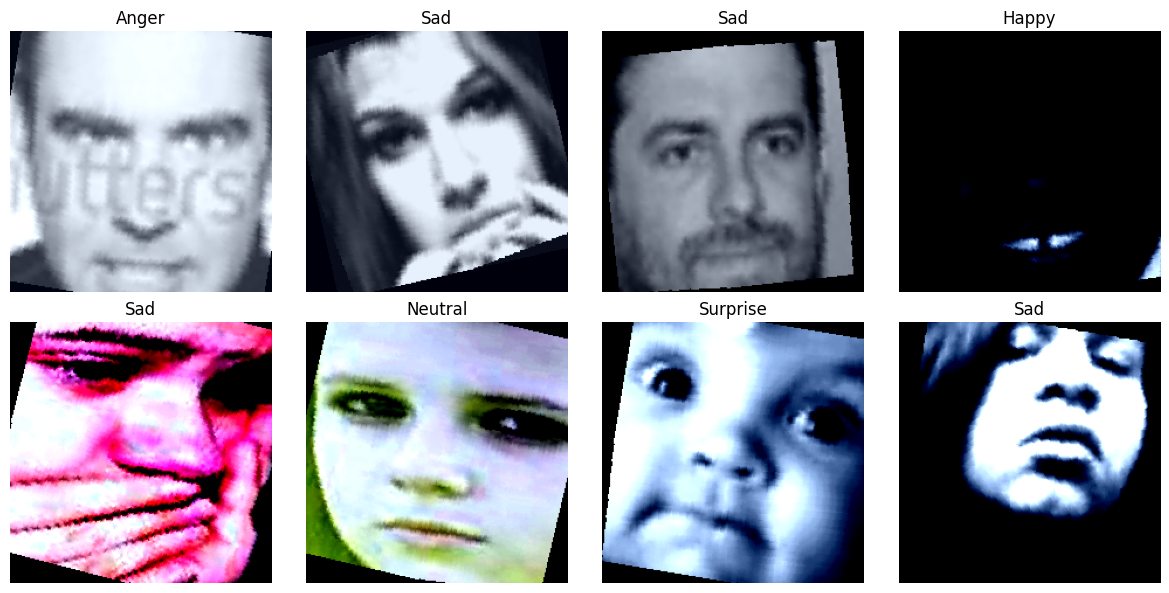

In [3]:
# After augmentation
# Function to denormalize images for visualization
def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    tensor = tensor.clone()  # Avoid modifying the original tensor
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)  # Reverse normalization: (tensor * std) + mean
    return tensor

# Get a batch of training images
images, labels = next(iter(train_loader))

# Denormalize images for visualization
images = denormalize(images)

# Print the number of images in the batch
print(f"Number of images processed in this batch: {images.shape[0]}")
print(f"Number of images displayed: 8")

# Plot the first 8 images in the batch
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.ravel()

for i in range(8):
    img = images[i].permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
    img = np.clip(img, 0, 1)  # Ensure pixel values are in [0, 1]
    axes[i].imshow(img)  # Since images are grayscale with 3 channels, this will show as grayscale
    axes[i].set_title(emotion_labels[labels[i].item()])
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [4]:
# Step 1: Define Squeeze-and-Excitation (SE) Block
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

# Step 2: Define Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_ch)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_ch != out_ch:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_ch)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)

# Step 3: Define ResEmoteNet with SE Blocks
class ResEmoteNet(nn.Module):
    def __init__(self, num_classes=7):
        super(ResEmoteNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)

        self.se = SEBlock(256)

        self.res_block1 = ResidualBlock(256, 512, stride=2)
        self.res_block2 = ResidualBlock(512, 1024, stride=2)
        self.res_block3 = ResidualBlock(1024, 2048, stride=2)

        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, num_classes)

        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.4)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)

        x = self.se(x)

        x = self.res_block1(x)
        x = self.res_block2(x)
        x = self.res_block3(x)

        x = self.pool(x)
        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.dropout2(x)
        x = self.fc4(x)
        return x

# Step 4: Initialize Device, Model, Loss, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResEmoteNet(num_classes=7).to(device)

# Step 5: Print total parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")

# Step 6: Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
scaler = torch.amp.GradScaler('cuda')

# Step 7: Checkpoint Management
checkpoint_dir = "/kaggle/working/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

start_epoch = 0
best_acc = 0.0
checkpoint_path = os.path.join(checkpoint_dir, "checkpoint.pth")

train_losses, val_losses = [], []
train_accs, val_accs = [], []

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_acc = checkpoint['best_acc']
    train_losses = checkpoint.get('train_losses', [])
    val_losses = checkpoint.get('val_losses', [])
    train_accs = checkpoint.get('train_accs', [])
    val_accs = checkpoint.get('val_accs', [])

    print(f"Resumed training from epoch {start_epoch} with best accuracy {best_acc:.2f}%")

80,238,599 total parameters.


In [5]:
# Training loop
patience = 15
epochs_no_improve = 0
num_epochs = 200
best_model_path = "/kaggle/working/best_resemotenet_model.pth"
last_checkpoint_path = checkpoint_path

for epoch in range(start_epoch, num_epochs):
    # Training Phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    train_progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]")
    for imgs, labels in train_progress:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        with torch.amp.autocast('cuda'):
            outputs = model(imgs)
            loss = criterion(outputs, labels)
        if torch.isnan(loss):
            print(f"NaN loss detected at epoch {epoch+1}. Skipping batch.")
            continue
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        train_progress.set_postfix({'loss': running_loss / (len(train_progress) + 1)})

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation Phase
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    
    val_progress = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]")
    with torch.no_grad():
        for images, labels in val_progress:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_progress.set_postfix({'loss': val_running_loss / (len(val_progress) + 1)})

    val_loss = val_running_loss / len(val_loader)
    val_acc = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Print summary
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"  Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc:.2f}%")

    # Save checkpoint
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_acc': best_acc,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs
    }
    torch.save(checkpoint, last_checkpoint_path)

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        epochs_no_improve = 0
        torch.save(model.state_dict(), best_model_path)
        print(f"New best model saved with Val Acc: {best_acc:.2f}%")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epoch(s).")
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

    scheduler.step(val_loss)

Epoch 1/200 [Validation]: 100%|██████████| 354/354 [00:41<00:00,  8.61it/s, loss=1.9]


Epoch [1/200]
  Train Loss: 1.9107, Train Acc: 19.07%
  Val   Loss: 1.9039, Val   Acc: 19.17%
New best model saved with Val Acc: 19.17%


Epoch 2/200 [Validation]: 100%|██████████| 354/354 [00:39<00:00,  9.01it/s, loss=1.86]


Epoch [2/200]
  Train Loss: 1.8864, Train Acc: 20.55%
  Val   Loss: 1.8664, Val   Acc: 20.37%
New best model saved with Val Acc: 20.37%


Epoch 3/200 [Validation]: 100%|██████████| 354/354 [00:39<00:00,  8.98it/s, loss=1.81]


Epoch [3/200]
  Train Loss: 1.8287, Train Acc: 22.91%
  Val   Loss: 1.8190, Val   Acc: 21.86%
New best model saved with Val Acc: 21.86%


Epoch 4/200 [Validation]: 100%|██████████| 354/354 [00:39<00:00,  8.98it/s, loss=1.78]


Epoch [4/200]
  Train Loss: 1.8001, Train Acc: 23.85%
  Val   Loss: 1.7846, Val   Acc: 22.66%
New best model saved with Val Acc: 22.66%


Epoch 5/200 [Validation]: 100%|██████████| 354/354 [00:39<00:00,  9.04it/s, loss=1.73]


Epoch [5/200]
  Train Loss: 1.7629, Train Acc: 24.56%
  Val   Loss: 1.7358, Val   Acc: 23.90%
New best model saved with Val Acc: 23.90%


Epoch 6/200 [Validation]: 100%|██████████| 354/354 [00:38<00:00,  9.09it/s, loss=1.71]


Epoch [6/200]
  Train Loss: 1.7188, Train Acc: 25.64%
  Val   Loss: 1.7195, Val   Acc: 25.73%
New best model saved with Val Acc: 25.73%


Epoch 7/200 [Validation]: 100%|██████████| 354/354 [00:39<00:00,  9.05it/s, loss=1.67]


Epoch [7/200]
  Train Loss: 1.6826, Train Acc: 27.26%
  Val   Loss: 1.6772, Val   Acc: 26.95%
New best model saved with Val Acc: 26.95%


Epoch 8/200 [Validation]: 100%|██████████| 354/354 [00:38<00:00,  9.08it/s, loss=1.72]


Epoch [8/200]
  Train Loss: 1.6509, Train Acc: 28.73%
  Val   Loss: 1.7276, Val   Acc: 28.45%
New best model saved with Val Acc: 28.45%


Epoch 9/200 [Validation]: 100%|██████████| 354/354 [00:39<00:00,  8.97it/s, loss=1.58]


Epoch [9/200]
  Train Loss: 1.6176, Train Acc: 30.34%
  Val   Loss: 1.5852, Val   Acc: 31.39%
New best model saved with Val Acc: 31.39%


Epoch 10/200 [Validation]: 100%|██████████| 354/354 [00:40<00:00,  8.83it/s, loss=1.6]


Epoch [10/200]
  Train Loss: 1.5745, Train Acc: 33.13%
  Val   Loss: 1.6092, Val   Acc: 33.48%
New best model saved with Val Acc: 33.48%


Epoch 11/200 [Validation]: 100%|██████████| 354/354 [00:39<00:00,  8.85it/s, loss=1.54]


Epoch [11/200]
  Train Loss: 1.5284, Train Acc: 36.03%
  Val   Loss: 1.5479, Val   Acc: 34.62%
New best model saved with Val Acc: 34.62%


Epoch 12/200 [Validation]: 100%|██████████| 354/354 [00:40<00:00,  8.75it/s, loss=1.48]


Epoch [12/200]
  Train Loss: 1.4782, Train Acc: 39.65%
  Val   Loss: 1.4819, Val   Acc: 40.00%
New best model saved with Val Acc: 40.00%


Epoch 13/200 [Validation]: 100%|██████████| 354/354 [00:39<00:00,  8.89it/s, loss=1.43]


Epoch [13/200]
  Train Loss: 1.4328, Train Acc: 42.19%
  Val   Loss: 1.4306, Val   Acc: 42.25%
New best model saved with Val Acc: 42.25%


Epoch 14/200 [Validation]: 100%|██████████| 354/354 [00:40<00:00,  8.75it/s, loss=1.34]


Epoch [14/200]
  Train Loss: 1.3951, Train Acc: 43.59%
  Val   Loss: 1.3454, Val   Acc: 45.60%
New best model saved with Val Acc: 45.60%


Epoch 15/200 [Validation]: 100%|██████████| 354/354 [00:40<00:00,  8.68it/s, loss=1.32]


Epoch [15/200]
  Train Loss: 1.3548, Train Acc: 45.27%
  Val   Loss: 1.3277, Val   Acc: 46.86%
New best model saved with Val Acc: 46.86%


Epoch 16/200 [Validation]: 100%|██████████| 354/354 [00:39<00:00,  8.88it/s, loss=1.31]


Epoch [16/200]
  Train Loss: 1.3290, Train Acc: 47.00%
  Val   Loss: 1.3119, Val   Acc: 48.16%
New best model saved with Val Acc: 48.16%


Epoch 17/200 [Validation]: 100%|██████████| 354/354 [00:39<00:00,  8.85it/s, loss=1.29]


Epoch [17/200]
  Train Loss: 1.3036, Train Acc: 48.16%
  Val   Loss: 1.2923, Val   Acc: 49.61%
New best model saved with Val Acc: 49.61%


Epoch 18/200 [Validation]: 100%|██████████| 354/354 [00:40<00:00,  8.68it/s, loss=1.33]


Epoch [18/200]
  Train Loss: 1.2764, Train Acc: 49.46%
  Val   Loss: 1.3329, Val   Acc: 48.03%
No improvement for 1 epoch(s).


Epoch 19/200 [Validation]: 100%|██████████| 354/354 [00:40<00:00,  8.77it/s, loss=1.25]


Epoch [19/200]
  Train Loss: 1.2494, Train Acc: 50.19%
  Val   Loss: 1.2507, Val   Acc: 51.51%
New best model saved with Val Acc: 51.51%


Epoch 20/200 [Validation]: 100%|██████████| 354/354 [00:40<00:00,  8.74it/s, loss=1.29]


Epoch [20/200]
  Train Loss: 1.2318, Train Acc: 51.42%
  Val   Loss: 1.2891, Val   Acc: 50.28%
No improvement for 1 epoch(s).


Epoch 21/200 [Validation]: 100%|██████████| 354/354 [00:40<00:00,  8.68it/s, loss=1.29]


Epoch [21/200]
  Train Loss: 1.2059, Train Acc: 52.87%
  Val   Loss: 1.2961, Val   Acc: 49.71%
No improvement for 2 epoch(s).


Epoch 22/200 [Validation]: 100%|██████████| 354/354 [00:40<00:00,  8.69it/s, loss=1.22]


Epoch [22/200]
  Train Loss: 1.1937, Train Acc: 53.74%
  Val   Loss: 1.2217, Val   Acc: 53.30%
New best model saved with Val Acc: 53.30%


Epoch 23/200 [Validation]: 100%|██████████| 354/354 [00:40<00:00,  8.78it/s, loss=1.27]


Epoch [23/200]
  Train Loss: 1.1709, Train Acc: 55.04%
  Val   Loss: 1.2750, Val   Acc: 51.41%
No improvement for 1 epoch(s).


Epoch 24/200 [Validation]: 100%|██████████| 354/354 [00:40<00:00,  8.81it/s, loss=1.25]


Epoch [24/200]
  Train Loss: 1.1545, Train Acc: 55.86%
  Val   Loss: 1.2516, Val   Acc: 52.95%
No improvement for 2 epoch(s).


Epoch 25/200 [Validation]: 100%|██████████| 354/354 [00:40<00:00,  8.77it/s, loss=1.12]


Epoch [25/200]
  Train Loss: 1.1310, Train Acc: 56.90%
  Val   Loss: 1.1268, Val   Acc: 57.33%
New best model saved with Val Acc: 57.33%


Epoch 26/200 [Validation]: 100%|██████████| 354/354 [00:40<00:00,  8.77it/s, loss=1.22]


Epoch [26/200]
  Train Loss: 1.1110, Train Acc: 57.73%
  Val   Loss: 1.2201, Val   Acc: 54.66%
No improvement for 1 epoch(s).


Epoch 27/200 [Validation]: 100%|██████████| 354/354 [00:40<00:00,  8.83it/s, loss=1.2]


Epoch [27/200]
  Train Loss: 1.0992, Train Acc: 58.61%
  Val   Loss: 1.2067, Val   Acc: 55.46%
No improvement for 2 epoch(s).


Epoch 28/200 [Validation]: 100%|██████████| 354/354 [00:38<00:00,  9.19it/s, loss=1.09]


Epoch [28/200]
  Train Loss: 1.0795, Train Acc: 59.28%
  Val   Loss: 1.0911, Val   Acc: 58.85%
New best model saved with Val Acc: 58.85%


Epoch 29/200 [Validation]: 100%|██████████| 354/354 [00:40<00:00,  8.77it/s, loss=1.12]


Epoch [29/200]
  Train Loss: 1.0618, Train Acc: 60.05%
  Val   Loss: 1.1249, Val   Acc: 57.69%
No improvement for 1 epoch(s).


Epoch 30/200 [Validation]: 100%|██████████| 354/354 [00:40<00:00,  8.74it/s, loss=1.05]


Epoch [30/200]
  Train Loss: 1.0500, Train Acc: 60.61%
  Val   Loss: 1.0543, Val   Acc: 60.51%
New best model saved with Val Acc: 60.51%


Epoch 31/200 [Validation]: 100%|██████████| 354/354 [00:39<00:00,  9.05it/s, loss=1.08]


Epoch [31/200]
  Train Loss: 1.0401, Train Acc: 61.34%
  Val   Loss: 1.0835, Val   Acc: 59.75%
No improvement for 1 epoch(s).


Epoch 32/200 [Validation]: 100%|██████████| 354/354 [00:39<00:00,  9.05it/s, loss=1.03]


Epoch [32/200]
  Train Loss: 1.0218, Train Acc: 62.05%
  Val   Loss: 1.0284, Val   Acc: 61.70%
New best model saved with Val Acc: 61.70%


Epoch 33/200 [Validation]: 100%|██████████| 354/354 [00:41<00:00,  8.54it/s, loss=1.06]


Epoch [33/200]
  Train Loss: 1.0049, Train Acc: 62.92%
  Val   Loss: 1.0671, Val   Acc: 60.06%
No improvement for 1 epoch(s).


Epoch 34/200 [Validation]: 100%|██████████| 354/354 [00:41<00:00,  8.61it/s, loss=1.01]


Epoch [34/200]
  Train Loss: 0.9957, Train Acc: 63.23%
  Val   Loss: 1.0137, Val   Acc: 61.78%
New best model saved with Val Acc: 61.78%


Epoch 35/200 [Validation]: 100%|██████████| 354/354 [00:39<00:00,  9.00it/s, loss=1.02]


Epoch [35/200]
  Train Loss: 0.9879, Train Acc: 63.61%
  Val   Loss: 1.0206, Val   Acc: 62.02%
New best model saved with Val Acc: 62.02%


Epoch 36/200 [Validation]: 100%|██████████| 354/354 [00:38<00:00,  9.21it/s, loss=0.991]


Epoch [36/200]
  Train Loss: 0.9741, Train Acc: 64.42%
  Val   Loss: 0.9936, Val   Acc: 63.00%
New best model saved with Val Acc: 63.00%


Epoch 37/200 [Validation]: 100%|██████████| 354/354 [00:38<00:00,  9.11it/s, loss=1.01]


Epoch [37/200]
  Train Loss: 0.9615, Train Acc: 64.69%
  Val   Loss: 1.0102, Val   Acc: 62.79%
No improvement for 1 epoch(s).


Epoch 38/200 [Validation]: 100%|██████████| 354/354 [00:41<00:00,  8.58it/s, loss=0.974]


Epoch [38/200]
  Train Loss: 0.9520, Train Acc: 65.06%
  Val   Loss: 0.9771, Val   Acc: 63.40%
New best model saved with Val Acc: 63.40%


Epoch 39/200 [Validation]: 100%|██████████| 354/354 [00:41<00:00,  8.57it/s, loss=1.02]


Epoch [39/200]
  Train Loss: 0.9345, Train Acc: 65.62%
  Val   Loss: 1.0231, Val   Acc: 62.68%
No improvement for 1 epoch(s).


Epoch 40/200 [Validation]: 100%|██████████| 354/354 [00:41<00:00,  8.60it/s, loss=1.02]


Epoch [40/200]
  Train Loss: 0.9301, Train Acc: 66.01%
  Val   Loss: 1.0190, Val   Acc: 62.37%
No improvement for 2 epoch(s).


Epoch 41/200 [Validation]: 100%|██████████| 354/354 [00:39<00:00,  8.90it/s, loss=0.994]


Epoch [41/200]
  Train Loss: 0.9214, Train Acc: 66.44%
  Val   Loss: 0.9964, Val   Acc: 63.54%
New best model saved with Val Acc: 63.54%


Epoch 42/200 [Validation]: 100%|██████████| 354/354 [00:38<00:00,  9.19it/s, loss=0.983]


Epoch [42/200]
  Train Loss: 0.9091, Train Acc: 66.60%
  Val   Loss: 0.9857, Val   Acc: 63.98%
New best model saved with Val Acc: 63.98%


Epoch 43/200 [Validation]: 100%|██████████| 354/354 [00:38<00:00,  9.27it/s, loss=0.942]


Epoch [43/200]
  Train Loss: 0.9041, Train Acc: 67.03%
  Val   Loss: 0.9450, Val   Acc: 65.28%
New best model saved with Val Acc: 65.28%


Epoch 44/200 [Validation]: 100%|██████████| 354/354 [00:38<00:00,  9.20it/s, loss=0.96]


Epoch [44/200]
  Train Loss: 0.8916, Train Acc: 67.50%
  Val   Loss: 0.9632, Val   Acc: 64.30%
No improvement for 1 epoch(s).


Epoch 45/200 [Validation]: 100%|██████████| 354/354 [00:38<00:00,  9.16it/s, loss=0.957]


Epoch [45/200]
  Train Loss: 0.8825, Train Acc: 67.97%
  Val   Loss: 0.9595, Val   Acc: 65.25%
No improvement for 2 epoch(s).


Epoch 46/200 [Validation]: 100%|██████████| 354/354 [00:38<00:00,  9.16it/s, loss=0.942]


Epoch [46/200]
  Train Loss: 0.8659, Train Acc: 68.42%
  Val   Loss: 0.9443, Val   Acc: 65.28%
No improvement for 3 epoch(s).


Epoch 47/200 [Validation]: 100%|██████████| 354/354 [00:38<00:00,  9.16it/s, loss=0.939]


Epoch [47/200]
  Train Loss: 0.8572, Train Acc: 68.80%
  Val   Loss: 0.9414, Val   Acc: 64.70%
No improvement for 4 epoch(s).


Epoch 48/200 [Validation]: 100%|██████████| 354/354 [00:38<00:00,  9.24it/s, loss=0.963]


Epoch [48/200]
  Train Loss: 0.8554, Train Acc: 69.07%
  Val   Loss: 0.9659, Val   Acc: 64.74%
No improvement for 5 epoch(s).


Epoch 49/200 [Validation]: 100%|██████████| 354/354 [00:38<00:00,  9.15it/s, loss=0.986]


Epoch [49/200]
  Train Loss: 0.8414, Train Acc: 69.47%
  Val   Loss: 0.9892, Val   Acc: 64.39%
No improvement for 6 epoch(s).


Epoch 50/200 [Validation]: 100%|██████████| 354/354 [00:38<00:00,  9.22it/s, loss=0.951]


Epoch [50/200]
  Train Loss: 0.8350, Train Acc: 69.77%
  Val   Loss: 0.9537, Val   Acc: 65.96%
New best model saved with Val Acc: 65.96%


Epoch 51/200 [Validation]: 100%|██████████| 354/354 [00:38<00:00,  9.21it/s, loss=0.93]


Epoch [51/200]
  Train Loss: 0.8282, Train Acc: 70.05%
  Val   Loss: 0.9323, Val   Acc: 65.83%
No improvement for 1 epoch(s).


Epoch 52/200 [Validation]: 100%|██████████| 354/354 [00:38<00:00,  9.17it/s, loss=0.904]


Epoch [52/200]
  Train Loss: 0.8225, Train Acc: 70.81%
  Val   Loss: 0.9066, Val   Acc: 67.46%
New best model saved with Val Acc: 67.46%


Epoch 53/200 [Validation]: 100%|██████████| 354/354 [00:38<00:00,  9.17it/s, loss=0.911]


Epoch [53/200]
  Train Loss: 0.8062, Train Acc: 71.03%
  Val   Loss: 0.9132, Val   Acc: 66.78%
No improvement for 1 epoch(s).


Epoch 54/200 [Validation]: 100%|██████████| 354/354 [00:39<00:00,  9.02it/s, loss=0.871]


Epoch [54/200]
  Train Loss: 0.7994, Train Acc: 71.19%
  Val   Loss: 0.8732, Val   Acc: 67.75%
New best model saved with Val Acc: 67.75%


Epoch 55/200 [Validation]: 100%|██████████| 354/354 [00:40<00:00,  8.82it/s, loss=0.9]


Epoch [55/200]
  Train Loss: 0.7892, Train Acc: 71.49%
  Val   Loss: 0.9022, Val   Acc: 67.10%
No improvement for 1 epoch(s).


Epoch 56/200 [Validation]: 100%|██████████| 354/354 [00:38<00:00,  9.23it/s, loss=0.877]


Epoch [56/200]
  Train Loss: 0.7782, Train Acc: 72.13%
  Val   Loss: 0.8794, Val   Acc: 67.84%
New best model saved with Val Acc: 67.84%


Epoch 57/200 [Validation]: 100%|██████████| 354/354 [00:38<00:00,  9.16it/s, loss=0.875]


Epoch [57/200]
  Train Loss: 0.7721, Train Acc: 72.47%
  Val   Loss: 0.8775, Val   Acc: 67.31%
No improvement for 1 epoch(s).


Epoch 58/200 [Validation]: 100%|██████████| 354/354 [00:42<00:00,  8.35it/s, loss=0.897]


Epoch [58/200]
  Train Loss: 0.7675, Train Acc: 72.53%
  Val   Loss: 0.8999, Val   Acc: 66.95%
No improvement for 2 epoch(s).


Epoch 59/200 [Validation]: 100%|██████████| 354/354 [00:42<00:00,  8.43it/s, loss=0.907]


Epoch [59/200]
  Train Loss: 0.7519, Train Acc: 73.13%
  Val   Loss: 0.9097, Val   Acc: 67.30%
No improvement for 3 epoch(s).


Epoch 60/200 [Validation]: 100%|██████████| 354/354 [00:38<00:00,  9.14it/s, loss=0.869]


Epoch [60/200]
  Train Loss: 0.7454, Train Acc: 73.35%
  Val   Loss: 0.8711, Val   Acc: 67.76%
No improvement for 4 epoch(s).


Epoch 61/200 [Validation]: 100%|██████████| 354/354 [00:38<00:00,  9.09it/s, loss=0.86]


Epoch [61/200]
  Train Loss: 0.7386, Train Acc: 73.60%
  Val   Loss: 0.8624, Val   Acc: 68.50%
New best model saved with Val Acc: 68.50%


Epoch 62/200 [Validation]: 100%|██████████| 354/354 [00:38<00:00,  9.20it/s, loss=0.859]


Epoch [62/200]
  Train Loss: 0.7379, Train Acc: 73.35%
  Val   Loss: 0.8612, Val   Acc: 68.95%
New best model saved with Val Acc: 68.95%


Epoch 63/200 [Validation]: 100%|██████████| 354/354 [00:38<00:00,  9.28it/s, loss=0.886]


Epoch [63/200]
  Train Loss: 0.7265, Train Acc: 74.17%
  Val   Loss: 0.8880, Val   Acc: 67.58%
No improvement for 1 epoch(s).


Epoch 64/200 [Validation]: 100%|██████████| 354/354 [01:04<00:00,  5.47it/s, loss=0.857]


Epoch [64/200]
  Train Loss: 0.7241, Train Acc: 74.20%
  Val   Loss: 0.8592, Val   Acc: 68.99%
New best model saved with Val Acc: 68.99%


Epoch 65/200 [Validation]: 100%|██████████| 354/354 [00:43<00:00,  8.13it/s, loss=0.896]


Epoch [65/200]
  Train Loss: 0.7075, Train Acc: 74.92%
  Val   Loss: 0.8986, Val   Acc: 67.65%
No improvement for 1 epoch(s).


Epoch 66/200 [Validation]: 100%|██████████| 354/354 [00:40<00:00,  8.81it/s, loss=0.946]


Epoch [66/200]
  Train Loss: 0.7018, Train Acc: 75.15%
  Val   Loss: 0.9484, Val   Acc: 66.21%
No improvement for 2 epoch(s).


Epoch 67/200 [Validation]: 100%|██████████| 354/354 [00:38<00:00,  9.14it/s, loss=0.871]


Epoch [67/200]
  Train Loss: 0.6968, Train Acc: 75.17%
  Val   Loss: 0.8738, Val   Acc: 67.81%
No improvement for 3 epoch(s).


Epoch 68/200 [Validation]: 100%|██████████| 354/354 [00:38<00:00,  9.23it/s, loss=0.906]


Epoch [68/200]
  Train Loss: 0.6824, Train Acc: 75.78%
  Val   Loss: 0.9088, Val   Acc: 68.07%
No improvement for 4 epoch(s).


Epoch 69/200 [Validation]: 100%|██████████| 354/354 [00:38<00:00,  9.22it/s, loss=0.871]


Epoch [69/200]
  Train Loss: 0.6732, Train Acc: 76.16%
  Val   Loss: 0.8731, Val   Acc: 68.52%
No improvement for 5 epoch(s).


Epoch 70/200 [Validation]: 100%|██████████| 354/354 [00:38<00:00,  9.13it/s, loss=0.892]


Epoch [70/200]
  Train Loss: 0.6686, Train Acc: 76.36%
  Val   Loss: 0.8944, Val   Acc: 67.92%
No improvement for 6 epoch(s).


Epoch 71/200 [Validation]: 100%|██████████| 354/354 [00:38<00:00,  9.14it/s, loss=0.795]


Epoch [71/200]
  Train Loss: 0.6073, Train Acc: 78.15%
  Val   Loss: 0.7974, Val   Acc: 71.32%
New best model saved with Val Acc: 71.32%


Epoch 72/200 [Validation]: 100%|██████████| 354/354 [00:38<00:00,  9.18it/s, loss=0.79]


Epoch [72/200]
  Train Loss: 0.5771, Train Acc: 79.58%
  Val   Loss: 0.7920, Val   Acc: 71.34%
New best model saved with Val Acc: 71.34%


Epoch 73/200 [Validation]: 100%|██████████| 354/354 [00:40<00:00,  8.64it/s, loss=0.789]


Epoch [73/200]
  Train Loss: 0.5615, Train Acc: 80.22%
  Val   Loss: 0.7910, Val   Acc: 71.47%
New best model saved with Val Acc: 71.47%


Epoch 74/200 [Validation]: 100%|██████████| 354/354 [00:43<00:00,  8.12it/s, loss=0.785]


Epoch [74/200]
  Train Loss: 0.5524, Train Acc: 80.40%
  Val   Loss: 0.7869, Val   Acc: 72.20%
New best model saved with Val Acc: 72.20%


Epoch 75/200 [Validation]: 100%|██████████| 354/354 [00:43<00:00,  8.19it/s, loss=0.775]


Epoch [75/200]
  Train Loss: 0.5474, Train Acc: 80.58%
  Val   Loss: 0.7770, Val   Acc: 71.68%
No improvement for 1 epoch(s).


Epoch 76/200 [Validation]: 100%|██████████| 354/354 [00:40<00:00,  8.75it/s, loss=0.783]


Epoch [76/200]
  Train Loss: 0.5415, Train Acc: 80.79%
  Val   Loss: 0.7854, Val   Acc: 72.01%
No improvement for 2 epoch(s).


Epoch 77/200 [Validation]: 100%|██████████| 354/354 [00:38<00:00,  9.19it/s, loss=0.794]


Epoch [77/200]
  Train Loss: 0.5366, Train Acc: 80.85%
  Val   Loss: 0.7967, Val   Acc: 71.82%
No improvement for 3 epoch(s).


Epoch 78/200 [Validation]: 100%|██████████| 354/354 [00:38<00:00,  9.18it/s, loss=0.779]


Epoch [78/200]
  Train Loss: 0.5221, Train Acc: 81.47%
  Val   Loss: 0.7814, Val   Acc: 72.37%
New best model saved with Val Acc: 72.37%


Epoch 79/200 [Validation]: 100%|██████████| 354/354 [00:38<00:00,  9.12it/s, loss=0.778]


Epoch [79/200]
  Train Loss: 0.5219, Train Acc: 81.49%
  Val   Loss: 0.7805, Val   Acc: 72.37%
No improvement for 1 epoch(s).


Epoch 80/200 [Validation]: 100%|██████████| 354/354 [00:39<00:00,  9.01it/s, loss=0.766]


Epoch [80/200]
  Train Loss: 0.5212, Train Acc: 81.44%
  Val   Loss: 0.7684, Val   Acc: 72.32%
No improvement for 2 epoch(s).


Epoch 81/200 [Validation]: 100%|██████████| 354/354 [00:38<00:00,  9.13it/s, loss=0.779]


Epoch [81/200]
  Train Loss: 0.5183, Train Acc: 81.72%
  Val   Loss: 0.7812, Val   Acc: 72.30%
No improvement for 3 epoch(s).


Epoch 82/200 [Validation]: 100%|██████████| 354/354 [00:39<00:00,  9.05it/s, loss=0.788]


Epoch [82/200]
  Train Loss: 0.5125, Train Acc: 81.87%
  Val   Loss: 0.7903, Val   Acc: 71.97%
No improvement for 4 epoch(s).


Epoch 83/200 [Validation]: 100%|██████████| 354/354 [00:38<00:00,  9.11it/s, loss=0.77]


Epoch [83/200]
  Train Loss: 0.5146, Train Acc: 81.70%
  Val   Loss: 0.7724, Val   Acc: 72.45%
New best model saved with Val Acc: 72.45%


Epoch 84/200 [Validation]: 100%|██████████| 354/354 [00:38<00:00,  9.11it/s, loss=0.772]


Epoch [84/200]
  Train Loss: 0.5010, Train Acc: 82.17%
  Val   Loss: 0.7742, Val   Acc: 72.37%
No improvement for 1 epoch(s).


Epoch 85/200 [Validation]: 100%|██████████| 354/354 [00:38<00:00,  9.16it/s, loss=0.786]


Epoch [85/200]
  Train Loss: 0.4970, Train Acc: 82.45%
  Val   Loss: 0.7878, Val   Acc: 72.00%
No improvement for 2 epoch(s).


Epoch 86/200 [Validation]: 100%|██████████| 354/354 [00:38<00:00,  9.19it/s, loss=0.765]


Epoch [86/200]
  Train Loss: 0.4972, Train Acc: 82.31%
  Val   Loss: 0.7670, Val   Acc: 73.09%
New best model saved with Val Acc: 73.09%


Epoch 87/200 [Validation]: 100%|██████████| 354/354 [00:38<00:00,  9.18it/s, loss=0.774]


Epoch [87/200]
  Train Loss: 0.4935, Train Acc: 82.37%
  Val   Loss: 0.7762, Val   Acc: 72.93%
No improvement for 1 epoch(s).


Epoch 88/200 [Validation]: 100%|██████████| 354/354 [00:38<00:00,  9.16it/s, loss=0.77]


Epoch [88/200]
  Train Loss: 0.4866, Train Acc: 82.71%
  Val   Loss: 0.7718, Val   Acc: 73.05%
No improvement for 2 epoch(s).


Epoch 89/200 [Validation]: 100%|██████████| 354/354 [00:38<00:00,  9.13it/s, loss=0.754]


Epoch [89/200]
  Train Loss: 0.4923, Train Acc: 82.58%
  Val   Loss: 0.7558, Val   Acc: 72.82%
No improvement for 3 epoch(s).


Epoch 90/200 [Validation]: 100%|██████████| 354/354 [00:39<00:00,  9.07it/s, loss=0.776]


Epoch [90/200]
  Train Loss: 0.4861, Train Acc: 82.71%
  Val   Loss: 0.7781, Val   Acc: 72.66%
No improvement for 4 epoch(s).


Epoch 91/200 [Validation]: 100%|██████████| 354/354 [00:39<00:00,  9.06it/s, loss=0.767]


Epoch [91/200]
  Train Loss: 0.4853, Train Acc: 82.77%
  Val   Loss: 0.7691, Val   Acc: 73.07%
No improvement for 5 epoch(s).


Epoch 92/200 [Validation]: 100%|██████████| 354/354 [00:38<00:00,  9.13it/s, loss=0.771]


Epoch [92/200]
  Train Loss: 0.4791, Train Acc: 82.99%
  Val   Loss: 0.7730, Val   Acc: 72.78%
No improvement for 6 epoch(s).


Epoch 93/200 [Validation]: 100%|██████████| 354/354 [00:38<00:00,  9.15it/s, loss=0.771]


Epoch [93/200]
  Train Loss: 0.4794, Train Acc: 82.97%
  Val   Loss: 0.7734, Val   Acc: 73.13%
New best model saved with Val Acc: 73.13%


Epoch 94/200 [Validation]: 100%|██████████| 354/354 [00:39<00:00,  9.03it/s, loss=0.761]


Epoch [94/200]
  Train Loss: 0.4766, Train Acc: 83.28%
  Val   Loss: 0.7633, Val   Acc: 73.17%
New best model saved with Val Acc: 73.17%


Epoch 95/200 [Validation]: 100%|██████████| 354/354 [00:38<00:00,  9.16it/s, loss=0.761]


Epoch [95/200]
  Train Loss: 0.4732, Train Acc: 83.27%
  Val   Loss: 0.7636, Val   Acc: 73.05%
No improvement for 1 epoch(s).


Epoch 96/200 [Validation]: 100%|██████████| 354/354 [00:39<00:00,  8.98it/s, loss=0.768]


Epoch [96/200]
  Train Loss: 0.4707, Train Acc: 83.20%
  Val   Loss: 0.7697, Val   Acc: 73.48%
New best model saved with Val Acc: 73.48%


Epoch 97/200 [Validation]: 100%|██████████| 354/354 [00:38<00:00,  9.13it/s, loss=0.759]


Epoch [97/200]
  Train Loss: 0.4639, Train Acc: 83.67%
  Val   Loss: 0.7616, Val   Acc: 73.20%
No improvement for 1 epoch(s).


Epoch 98/200 [Validation]: 100%|██████████| 354/354 [00:38<00:00,  9.12it/s, loss=0.769]


Epoch [98/200]
  Train Loss: 0.4630, Train Acc: 83.62%
  Val   Loss: 0.7709, Val   Acc: 72.62%
No improvement for 2 epoch(s).


Epoch 99/200 [Validation]: 100%|██████████| 354/354 [00:38<00:00,  9.08it/s, loss=0.769]


Epoch [99/200]
  Train Loss: 0.4661, Train Acc: 83.41%
  Val   Loss: 0.7707, Val   Acc: 73.15%
No improvement for 3 epoch(s).


Epoch 100/200 [Validation]: 100%|██████████| 354/354 [00:38<00:00,  9.15it/s, loss=0.754]


Epoch [100/200]
  Train Loss: 0.4678, Train Acc: 83.25%
  Val   Loss: 0.7563, Val   Acc: 73.39%
No improvement for 4 epoch(s).


Epoch 101/200 [Validation]: 100%|██████████| 354/354 [00:38<00:00,  9.20it/s, loss=0.767]


Epoch [101/200]
  Train Loss: 0.4589, Train Acc: 83.72%
  Val   Loss: 0.7695, Val   Acc: 73.28%
No improvement for 5 epoch(s).


Epoch 102/200 [Validation]: 100%|██████████| 354/354 [00:39<00:00,  9.03it/s, loss=0.77]


Epoch [102/200]
  Train Loss: 0.4592, Train Acc: 83.71%
  Val   Loss: 0.7717, Val   Acc: 73.36%
No improvement for 6 epoch(s).


Epoch 103/200 [Validation]: 100%|██████████| 354/354 [00:39<00:00,  9.01it/s, loss=0.767]


Epoch [103/200]
  Train Loss: 0.4562, Train Acc: 83.79%
  Val   Loss: 0.7695, Val   Acc: 73.14%
No improvement for 7 epoch(s).


Epoch 104/200 [Validation]: 100%|██████████| 354/354 [00:39<00:00,  8.98it/s, loss=0.763]


Epoch [104/200]
  Train Loss: 0.4578, Train Acc: 83.86%
  Val   Loss: 0.7651, Val   Acc: 73.47%
No improvement for 8 epoch(s).


Epoch 105/200 [Validation]: 100%|██████████| 354/354 [00:38<00:00,  9.13it/s, loss=0.769]


Epoch [105/200]
  Train Loss: 0.4648, Train Acc: 83.56%
  Val   Loss: 0.7714, Val   Acc: 73.11%
No improvement for 9 epoch(s).


Epoch 106/200 [Validation]: 100%|██████████| 354/354 [00:39<00:00,  9.00it/s, loss=0.759]


Epoch [106/200]
  Train Loss: 0.4596, Train Acc: 83.65%
  Val   Loss: 0.7607, Val   Acc: 73.39%
No improvement for 10 epoch(s).


Epoch 107/200 [Validation]: 100%|██████████| 354/354 [00:39<00:00,  9.03it/s, loss=0.763]


Epoch [107/200]
  Train Loss: 0.4561, Train Acc: 83.77%
  Val   Loss: 0.7655, Val   Acc: 73.50%
New best model saved with Val Acc: 73.50%


Epoch 108/200 [Validation]: 100%|██████████| 354/354 [00:39<00:00,  8.98it/s, loss=0.782]


Epoch [108/200]
  Train Loss: 0.4585, Train Acc: 83.76%
  Val   Loss: 0.7843, Val   Acc: 72.79%
No improvement for 1 epoch(s).


Epoch 109/200 [Validation]: 100%|██████████| 354/354 [00:38<00:00,  9.08it/s, loss=0.758]


Epoch [109/200]
  Train Loss: 0.4562, Train Acc: 83.67%
  Val   Loss: 0.7605, Val   Acc: 73.55%
New best model saved with Val Acc: 73.55%


Epoch 110/200 [Validation]: 100%|██████████| 354/354 [00:38<00:00,  9.15it/s, loss=0.77]


Epoch [110/200]
  Train Loss: 0.4607, Train Acc: 83.53%
  Val   Loss: 0.7720, Val   Acc: 73.04%
No improvement for 1 epoch(s).


Epoch 111/200 [Validation]: 100%|██████████| 354/354 [00:52<00:00,  6.79it/s, loss=0.77]


Epoch [111/200]
  Train Loss: 0.4599, Train Acc: 83.82%
  Val   Loss: 0.7727, Val   Acc: 73.81%
New best model saved with Val Acc: 73.81%


Epoch 112/200 [Validation]: 100%|██████████| 354/354 [00:50<00:00,  6.95it/s, loss=0.756]


Epoch [112/200]
  Train Loss: 0.4598, Train Acc: 83.65%
  Val   Loss: 0.7586, Val   Acc: 73.47%
No improvement for 1 epoch(s).


Epoch 113/200 [Validation]: 100%|██████████| 354/354 [00:39<00:00,  8.99it/s, loss=0.761]


Epoch [113/200]
  Train Loss: 0.4591, Train Acc: 83.78%
  Val   Loss: 0.7629, Val   Acc: 73.49%
No improvement for 2 epoch(s).


Epoch 114/200 [Validation]: 100%|██████████| 354/354 [00:40<00:00,  8.76it/s, loss=0.759]


Epoch [114/200]
  Train Loss: 0.4622, Train Acc: 83.80%
  Val   Loss: 0.7613, Val   Acc: 73.10%
No improvement for 3 epoch(s).


Epoch 115/200 [Validation]: 100%|██████████| 354/354 [00:41<00:00,  8.53it/s, loss=0.762]


Epoch [115/200]
  Train Loss: 0.4617, Train Acc: 83.52%
  Val   Loss: 0.7646, Val   Acc: 73.56%
No improvement for 4 epoch(s).


Epoch 116/200 [Validation]: 100%|██████████| 354/354 [00:39<00:00,  9.07it/s, loss=0.754]


Epoch [116/200]
  Train Loss: 0.4606, Train Acc: 83.65%
  Val   Loss: 0.7558, Val   Acc: 73.58%
No improvement for 5 epoch(s).


Epoch 117/200 [Validation]: 100%|██████████| 354/354 [00:39<00:00,  8.98it/s, loss=0.763]


Epoch [117/200]
  Train Loss: 0.4598, Train Acc: 83.83%
  Val   Loss: 0.7655, Val   Acc: 72.94%
No improvement for 6 epoch(s).


Epoch 118/200 [Validation]: 100%|██████████| 354/354 [00:39<00:00,  8.99it/s, loss=0.755]


Epoch [118/200]
  Train Loss: 0.4576, Train Acc: 83.65%
  Val   Loss: 0.7569, Val   Acc: 73.65%
No improvement for 7 epoch(s).


Epoch 119/200 [Validation]: 100%|██████████| 354/354 [00:38<00:00,  9.09it/s, loss=0.767]


Epoch [119/200]
  Train Loss: 0.4613, Train Acc: 83.63%
  Val   Loss: 0.7690, Val   Acc: 73.13%
No improvement for 8 epoch(s).


Epoch 120/200 [Validation]: 100%|██████████| 354/354 [00:39<00:00,  9.05it/s, loss=0.758]


Epoch [120/200]
  Train Loss: 0.4577, Train Acc: 83.74%
  Val   Loss: 0.7603, Val   Acc: 73.52%
No improvement for 9 epoch(s).


Epoch 121/200 [Validation]: 100%|██████████| 354/354 [00:39<00:00,  9.00it/s, loss=0.769]


Epoch [121/200]
  Train Loss: 0.4610, Train Acc: 83.72%
  Val   Loss: 0.7711, Val   Acc: 73.00%
No improvement for 10 epoch(s).


Epoch 122/200 [Validation]: 100%|██████████| 354/354 [00:39<00:00,  9.00it/s, loss=0.754]


Epoch [122/200]
  Train Loss: 0.4551, Train Acc: 83.89%
  Val   Loss: 0.7566, Val   Acc: 73.52%
No improvement for 11 epoch(s).


Epoch 123/200 [Validation]: 100%|██████████| 354/354 [00:39<00:00,  9.00it/s, loss=0.755]


Epoch [123/200]
  Train Loss: 0.4597, Train Acc: 83.65%
  Val   Loss: 0.7569, Val   Acc: 73.40%
No improvement for 12 epoch(s).


Epoch 124/200 [Validation]: 100%|██████████| 354/354 [00:43<00:00,  8.11it/s, loss=0.772]


Epoch [124/200]
  Train Loss: 0.4567, Train Acc: 83.63%
  Val   Loss: 0.7744, Val   Acc: 73.33%
No improvement for 13 epoch(s).


Epoch 125/200 [Validation]: 100%|██████████| 354/354 [00:46<00:00,  7.59it/s, loss=0.767]


Epoch [125/200]
  Train Loss: 0.4616, Train Acc: 83.47%
  Val   Loss: 0.7695, Val   Acc: 73.16%
No improvement for 14 epoch(s).


Epoch 126/200 [Validation]: 100%|██████████| 354/354 [00:42<00:00,  8.25it/s, loss=0.77]


Epoch [126/200]
  Train Loss: 0.4566, Train Acc: 83.71%
  Val   Loss: 0.7718, Val   Acc: 73.18%
No improvement for 15 epoch(s).
Early stopping triggered.


In [6]:
# Save Final Model
torch.save(model.state_dict(), "/kaggle/working/resemotenet_model.pth")
print("Saved final model state to /kaggle/working/resemotenet_model.pth")

Saved final model state to /kaggle/working/resemotenet_model.pth


Loaded best model for evaluation.


Evaluating on Test Set: 100%|██████████| 567/567 [00:52<00:00, 10.71it/s]



Test Accuracy: 68.06%

Precision (macro): 67.43%
Recall (macro): 66.95%
F1-score (macro): 66.84%
ROC-AUC (macro): 0.90

Classification Report:
              precision    recall  f1-score   support

       Happy       0.89      0.89      0.89      2838
    Surprise       0.69      0.57      0.63      2711
         Sad       0.61      0.75      0.67      2704
       Anger       0.64      0.59      0.61      2838
     Disgust       0.61      0.53      0.57      1519
        Fear       0.60      0.53      0.56      2696
     Neutral       0.69      0.83      0.75      2838

    accuracy                           0.68     18144
   macro avg       0.67      0.67      0.67     18144
weighted avg       0.68      0.68      0.68     18144



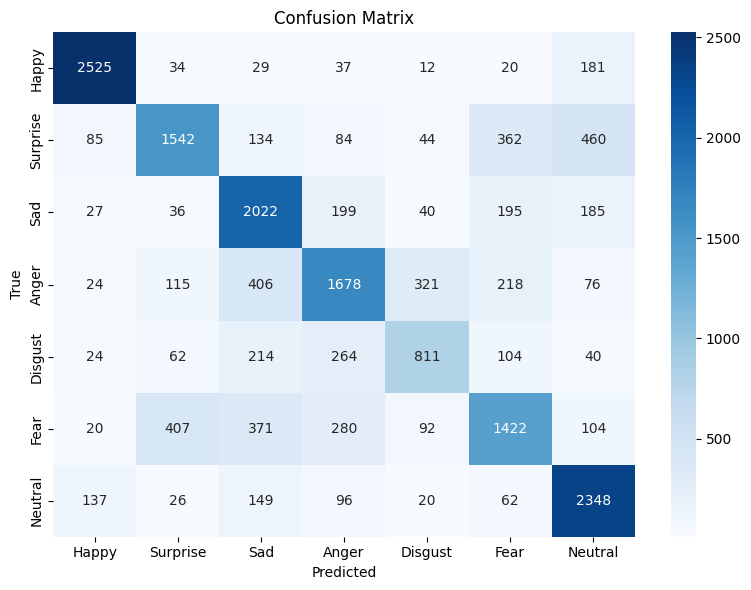

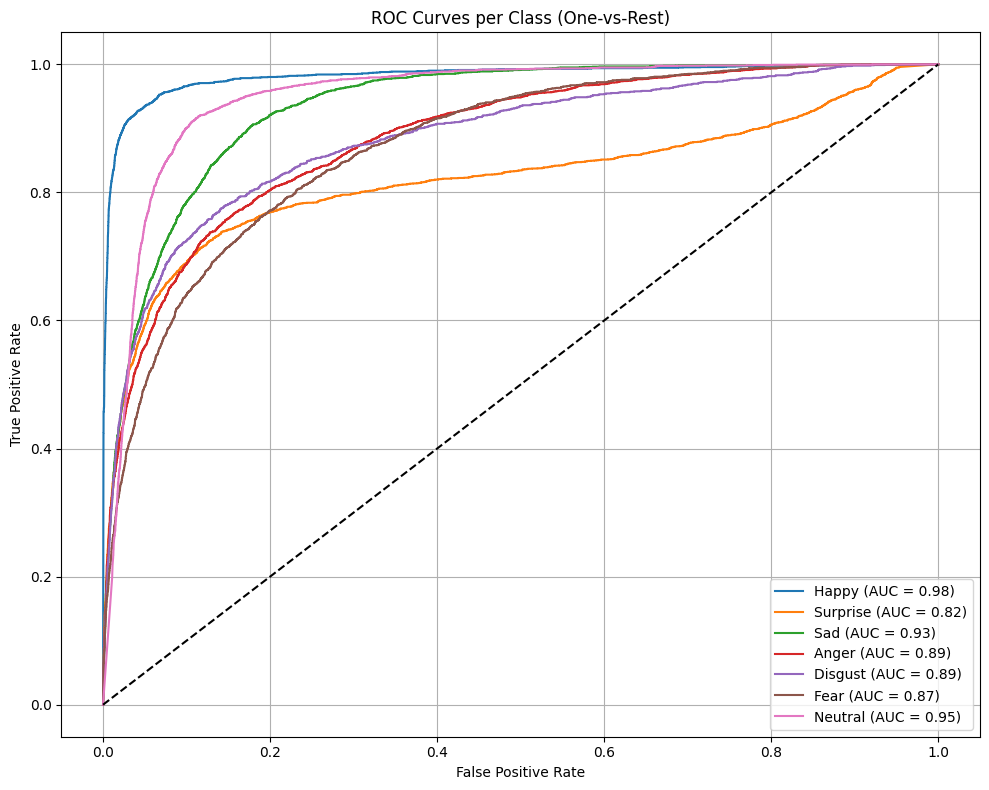

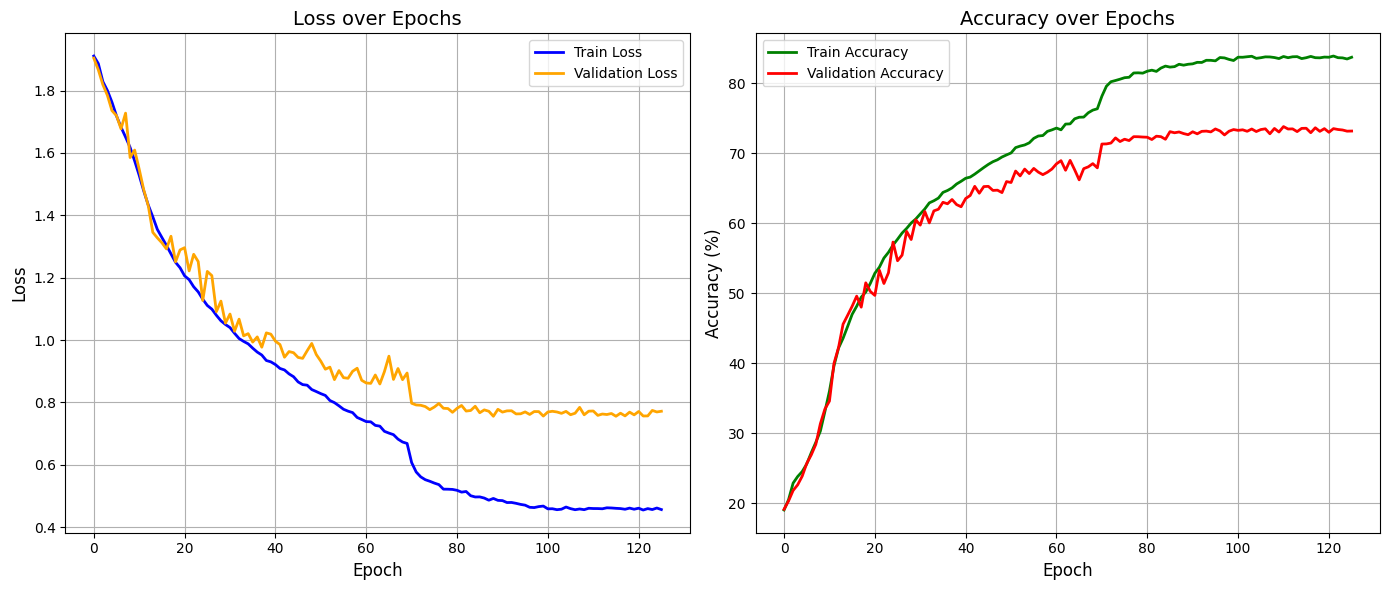

Saved training curves to `/kaggle/working/training_curves.png`


In [7]:
# Evaluate model
# Load Best Model
best_model_path = "/kaggle/working/best_resemotenet_model.pth"
last_checkpoint_path = "/kaggle/working/checkpoints/checkpoint_resemotenet_model.pth"

if os.path.exists(best_model_path):
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    print("Loaded best model for evaluation.")
elif os.path.exists(last_checkpoint_path):
    checkpoint = torch.load(last_checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print("Loaded last checkpoint model (best model not found).")
else:
    print("No model found.")
    test_acc = 0.0

# Inference Loop
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating on Test Set"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)

        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Basic Accuracy
test_acc = 100 * correct / total if total > 0 else 0.0
print(f"\nTest Accuracy: {test_acc:.2f}%")

# Convert to numpy arrays
y_true = np.array(all_labels)
y_pred = np.array(all_preds)
y_prob = np.array(all_probs)
y_true_bin = label_binarize(y_true, classes=range(7))  # 7 classes

# Metrics
precision = precision_score(y_true, y_pred, average='macro') * 100
recall = recall_score(y_true, y_pred, average='macro') * 100
f1 = f1_score(y_true, y_pred, average='macro') * 100
roc_auc = roc_auc_score(y_true_bin, y_prob, average='macro', multi_class='ovr')

print(f"\nPrecision (macro): {precision:.2f}%")
print(f"Recall (macro): {recall:.2f}%")
print(f"F1-score (macro): {f1:.2f}%")
print(f"ROC-AUC (macro): {roc_auc:.2f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=list(emotion_labels.values())))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=emotion_labels.values(), yticklabels=emotion_labels.values())
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# ROC Curve (One-vs-Rest)
fpr = dict()
tpr = dict()
roc_auc_per_class = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc_per_class[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(7):
    plt.plot(fpr[i], tpr[i], label=f'{emotion_labels[i]} (AUC = {roc_auc_per_class[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curves per Class (One-vs-Rest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()

# Step: Visualize plot training curve
if train_losses and val_losses and train_accs and val_accs:
    plt.figure(figsize=(14, 6))

    # Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss", color='blue', linewidth=2)
    plt.plot(val_losses, label="Validation Loss", color='orange', linewidth=2)
    plt.title("Loss over Epochs", fontsize=14)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.legend()
    plt.grid(True)

    # Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label="Train Accuracy", color='green', linewidth=2)
    plt.plot(val_accs, label="Validation Accuracy", color='red', linewidth=2)
    plt.title("Accuracy over Epochs", fontsize=14)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Accuracy (%)", fontsize=12)
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig("/kaggle/working/training_curves.png")
    plt.show()
    print("Saved training curves to `/kaggle/working/training_curves.png`")
else:
    print("Training curves not plotted. Lists are empty (training may not have completed).")